In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import csv
import numpy as np

from nltk.util import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from itertools import compress


#### Load Recipes Data

In [2]:
recipes = json.load(open('./data/recipe_train.json'))

for dic in recipes:
    ingredients = []
    for ingredient in dic['ingredients']:
        tmp_ingredient = ingredient.replace(' ', '-')
        ingredients.append(tmp_ingredient)
        dic['ingredients'] = ingredients

#### Convert recipe to text document

In [3]:
recipes_as_doc = {}

for sample in recipes:
    key = sample['cuisine']
    # If key is in the dictionary, return its value. If not, insert key with a value of default and return default.
    recipes_as_doc.setdefault(key,[]).append(' '.join(sample['ingredients']).lower())

# create a single list with all the documents
all_docs = []
for k, v in recipes_as_doc.items():
   all_docs.append(' '.join(v))

#### Tfidf vectorizer for text data

In [4]:
# code adapted from https://programminghistorian.org/en/lessons/analyzing-documents-with-tfidf

vectorizer = TfidfVectorizer(use_idf=True, token_pattern=r"(?u)\b\w[\w-]*\w\b")
transformed_documents = vectorizer.fit_transform(all_docs)

#### Analyze results

In [5]:
transformed_documents_as_array = transformed_documents.toarray()
len(transformed_documents_as_array)
docs_scores_dfs = {}

# loop each item in transformed_documents_as_array, using enumerate to keep track of the current position
for counter, doc in enumerate(transformed_documents_as_array):
    # construct a data frame
    tf_idf_tuples = list(zip(vectorizer.get_feature_names(), doc))
    one_doc_as_df = pd.DataFrame\
        .from_records(tf_idf_tuples, columns=['term', 'score'])\
        .sort_values(by='score', ascending=False)\
        .reset_index(drop=True)
    docs_scores_dfs[list(recipes_as_doc.keys())[counter]] = one_doc_as_df

    print(list(recipes_as_doc.keys())[counter], end=' ')
    # print(one_doc_as_df)
    # output to a csv using the enumerated value for the filename
    #one_doc_as_df.to_csv("tf.idf" + counter.__str__() + ".csv")

greek southern_us filipino indian jamaican spanish italian mexican chinese british thai vietnamese cajun_creole brazilian french japanese irish korean moroccan russian 

#### Statistics of Scores

Text(0, 0.5, 'Number of Therms')

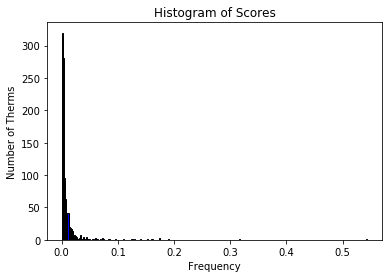

In [6]:
statistics = {}
for k in docs_scores_dfs.keys():
    df = docs_scores_dfs[k]
    scores = df['score']
    scores = scores.loc[scores>0.0]
    statistics[k] = [scores.mean(), scores.max(), scores.min(), df['score'].astype(bool).sum(axis=0)]

irish_scores = docs_scores_dfs["irish"]["score"]
irish_scores = irish_scores.loc[irish_scores>0.0]
plt.hist(irish_scores, color = 'blue', edgecolor = 'black', bins=300)
plt.title('Histogram of Scores')
plt.xlabel('Frequency')
plt.ylabel('Number of Therms')
# print(statistics)

#### Top 10 therms per cuisine

In [7]:
for k in docs_scores_dfs.keys():
    scores_df = docs_scores_dfs[k]
    print('-------------')
    print(k)
    print(scores_df.iloc[:15,:])


-------------
greek
                      term     score
0                     salt  0.418578
1                olive-oil  0.368817
2     feta-cheese-crumbles  0.303652
3            dried-oregano  0.248517
4              feta-cheese  0.230149
5            garlic-cloves  0.185872
6   extra-virgin-olive-oil  0.167578
7        fresh-lemon-juice  0.162455
8      ground-black-pepper  0.161723
9                   garlic  0.158065
10                  pepper  0.148551
11                cucumber  0.143519
12            purple-onion  0.136111
13                  onions  0.135379
14             lemon-juice  0.133916
-------------
southern_us
                   term     score
0                  salt  0.540956
1                butter  0.296463
2     all-purpose-flour  0.288667
3                 sugar  0.248982
4            buttermilk  0.181414
5            large-eggs  0.176224
6         baking-powder  0.172208
7                 water  0.162523
8       unsalted-butter  0.154728
9                  mil

#### Load Baskets Market Data

In [8]:
baskets = []
with open('./data/groceries.csv', newline=None) as f:
  reader = csv.reader(f)
  for row in reader:
    baskets.append([elem.replace(' ', '-') for elem in row])

#### Compute ngram for tf.idf top score 

In [9]:
top_scores_ngram = {}

for cuisine in docs_scores_dfs.keys():
    scores_df = docs_scores_dfs[cuisine]
    scores_df = scores_df[scores_df['score']>(statistics[cuisine][1]/4)]
    #scores_df = scores_df.iloc[:30,:]
    scores_df = scores_df.sort_values(by=['score'],ascending=False)
    
    ngram_scores = []
    for index, row in scores_df.iterrows():
        ngram = list(ngrams(row['term'], 3))
        score =  row['score']
        ngram_scores.append([ngram, score])
        
    top_scores_ngram[cuisine] = ngram_scores

#### Define the metric similarity

In [10]:
def jaccard_distance(a, b):
    """Calculate the jaccard distance between sets A and B"""
    a = set(a)
    b = set(b)
    return 1.0 * len(a&b)/len(a|b)

#### Compute Basket Scores
For each basket we iterate over all items and compute their similarities with the top 
terms in the cuisines docs

In [11]:
baskets_scores = []

for basket in baskets:
    similarities = {}
    for cuisine in top_scores_ngram:
        value = 0
        for item in basket:      
            item_ngram = list(ngrams(item, 3))
            for ngram_term, score in top_scores_ngram[cuisine]:
                sim = jaccard_distance(item_ngram, ngram_term)
                if sim > 0:
                    value += sim * score
                    
        similarities[cuisine] = value    
    baskets_scores.append(similarities)
           
    # print('------------------')
    # print("basket: ", basket)
    # for k in similarities:
    #     print(k, similarities[k]) 
baskets_scores_df = pd.DataFrame(baskets_scores)
baskets_scores_df=(baskets_scores_df-baskets_scores_df.mean())/baskets_scores_df.std()

#### CLustering baskets
We now try to cluster the baskets, based on the scores that they 
obtained using frequent therms of recipes

In [12]:
X = StandardScaler().fit_transform(baskets_scores_df.to_numpy())

In [13]:
# OPTICS
optics = OPTICS(min_samples=50, max_eps=0.1, xi=.05, min_cluster_size=.05)
optics.fit(X)
optics_labels = optics.labels_[optics.ordering_]
print(set(optics_labels))

{-1}


In [14]:
# K-Means
kMeans = KMeans(n_clusters=10, random_state=0).fit(X)
kMeans_labels = kMeans.labels_
print(set(kMeans_labels))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


In [15]:
# DBSCAN 
[eps, min_samples] = [0.35, 50]
dbScan = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
dbScan_labels = dbScan.labels_
print(set(dbScan_labels))
print([eps, min_samples])

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, -1}
[0.35, 50]


#### Analysis of the method
Observe size of created basket clusters

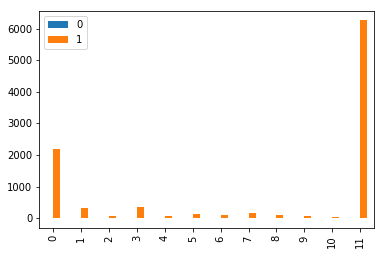

In [16]:
labels = dbScan_labels
cluster_sizes = []
for label in set(labels):
    cluster_sizes.append([label, len(baskets_scores_df[labels == label])])
pd.DataFrame(cluster_sizes).plot(kind='bar')

Select one cluster and calculate its overall score (by summing
all scores of all items of that cluster)

In [17]:
for selected_basket_cluster in set(labels):
    print("Cluster ", selected_basket_cluster)
    selected_basket_scores = baskets_scores_df[labels == selected_basket_cluster]
    aggregated_basket_cluster_score \
        = np.sum(selected_basket_scores, axis=0)\
        .sort_values(ascending=False)
    selected_baskets = list(compress(baskets, labels == selected_basket_cluster))
    selected_baskets = [' '.join(l) for l in selected_baskets]
    aggregated_basket_cluster_score = aggregated_basket_cluster_score[0:50]
    print(aggregated_basket_cluster_score)

Cluster  0
spanish        -1173.001160
vietnamese     -1192.835282
french         -1208.453710
filipino       -1248.738374
moroccan       -1289.073450
korean         -1296.453947
russian        -1310.874224
irish          -1313.692058
italian        -1322.967538
brazilian      -1335.228804
southern_us    -1349.893963
british        -1404.304004
greek          -1419.592302
indian         -1465.147722
mexican        -1565.491891
jamaican       -1579.325436
japanese       -1648.336393
cajun_creole   -1659.321442
chinese        -1737.204688
thai           -1898.622221
dtype: float64
Cluster  1
brazilian       -48.827402
southern_us     -87.674371
british         -90.348149
irish          -115.953361
thai           -137.747590
jamaican       -158.970531
vietnamese     -178.623755
filipino       -191.944467
cajun_creole   -194.148871
french         -197.807994
indian         -198.100438
spanish        -199.992649
russian        -201.878613
greek          -208.055701
korean         -208.28203

#### Baseline method - K-means
Now we will implement the baseline algorithm to compare our method with. 
A KNN method will be used. We will try to find the best K by trial and error based on the
coherence of the results because there are not many possible Ks for the given dataset.

In [18]:
baskets_as_docs = [' '.join(basket) for basket in baskets]
X = vectorizer.fit_transform(baskets_as_docs)
model = KMeans(n_clusters=10, init='k-means++', max_iter=100, n_init=1)
model.fit(X)

print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
baseline_labels = set(model.labels_)
for i in baseline_labels:
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])

Top terms per cluster:
Cluster 0:
 whipped
 sour-cream
 whole-milk
 other-vegetables
 yogurt
 root-vegetables
 curd
 berries
 tropical-fruit
 buns
Cluster 1:
 bottled-beer
 yogurt
 newspapers
 tropical-fruit
 beverages
 coffee
 root-vegetables
 pip-fruit
 sausage
 bottled-water
Cluster 2:
 pastry
 whole-milk
 soda
 other-vegetables
 brown-bread
 sausage
 yogurt
 tropical-fruit
 pip-fruit
 waffles
Cluster 3:
 soda
 bottled-water
 bottled-beer
 specialty-chocolate
 specialty-bar
 frozen-meals
 whole-milk
 uht-milk
 chocolate
 sausage
Cluster 4:
 buns
 rolls
 whole-milk
 soda
 sausage
 other-vegetables
 yogurt
 frankfurter
 bottled-water
 newspapers
Cluster 5:
 whole-milk
 bottled-water
 yogurt
 newspapers
 tropical-fruit
 root-vegetables
 brown-bread
 curd
 pip-fruit
 citrus-fruit
Cluster 6:
 vegetable-juice
 fruit
 whole-milk
 soda
 other-vegetables
 yogurt
 bottled-water
 buns
 rolls
 tropical-fruit
Cluster 7:
 other-vegetables
 whole-milk
 root-vegetables
 citrus-fruit
 yogurt
 tropic

#### Compute Scores of Baskets created using K-Means
For the created clusters of baskets using the baseline method, 
we calculate its scores in terms of similarity with the terms
that scored high TF-IDF for the cuisines 

In [19]:
baseline_baskets_scores = {}
for cluster in baseline_labels:
    basket_scores = baskets_scores_df[model.labels_ == cluster]
    cluster_scores = np.sum(basket_scores, axis=0).sort_values(ascending=False)
    cluster_scores = cluster_scores[0:50]
    print(cluster_scores)

mexican         881.723697
russian         765.025918
cajun_creole    477.840714
greek           436.328780
jamaican        423.141916
italian         395.586177
british         386.176890
irish           384.062630
spanish         382.890822
southern_us     368.963851
moroccan        361.516072
thai            343.941967
french          340.758449
indian          340.616731
chinese         335.019266
filipino        315.088508
japanese        312.268149
brazilian       276.679998
korean          253.538889
vietnamese      196.070485
dtype: float64
vietnamese       -53.865805
filipino        -189.530350
spanish         -264.837105
italian         -278.023594
french          -288.699723
moroccan        -331.382034
korean          -365.104938
russian         -438.866712
brazilian       -447.196335
southern_us     -496.134135
irish           -524.792495
british         -544.954219
greek           -623.359358
indian          -632.930576
japanese        -695.118128
chinese         -733.1708